# 1.Linear regression-线性回归

## 1.1 导入包和模块
```
%matplotlib inline
```
表示在jupyter note中内嵌显示

In [18]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt 
import numpy as np
import random

## 2.1 生成数据集
构造人工训练集，样本数1000，输入特征个数2，批量样本特征$\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，
给定真实参数：权重$\boldsymbol{w}=[2,-3.4]^{\top}$和偏差b = 4.2，
叠加噪声项$\epsilon$，噪声项服从均值为0、标准差为0.01的正态分布
$$
\boldsymbol{y}=\boldsymbol{X} \boldsymbol{w}+b+\epsilon 
$$

In [20]:
num_inputs = 2
num_example = 1000
true_w = [2,3.4]
true_b = 4.2

features = torch.randn(num_example, num_inputs, dtype=torch.float32)
labels = true_w[0]*features[:,0] + true_w[1]*features[:,1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)
print(features[0], labels[0])

tensor([-0.9481, -0.9018])tensor(-0.7702)


## 2.2 显示函数
设置矢量图类型并设置图的尺寸

[-9.01799083e-01 -7.37895846e-01  3.09027046e-01  3.27082217e-01
  1.73812103e+00 -1.16662014e+00  1.16112268e+00  1.96040884e-01
  1.01631606e+00 -8.55131626e-01  4.29805458e-01 -5.35212696e-01
 -5.59403121e-01  5.01594365e-01 -1.34355283e+00 -1.27319241e+00
  6.81906402e-01  2.45312229e-01  6.49098516e-01 -6.37529314e-01
  7.29628205e-01  1.59210062e+00  1.92674458e+00 -4.47859257e-01
  1.10052431e+00  3.89890194e-01 -2.46756561e-02  6.01729155e-01
  9.58197176e-01  1.56325364e+00  2.15555310e-01  9.07990336e-01
 -8.33686113e-01  8.39865327e-01 -6.34886026e-01  4.75430161e-01
 -4.16892320e-01  1.49446696e-01  1.75264978e+00  6.49412453e-01
  2.02246174e-01  1.89460611e+00  1.05384827e+00 -2.64443994e-01
 -3.31699103e-01 -1.21474959e-01  1.66516423e+00 -4.55346517e-02
 -2.78642386e-01 -9.95931923e-01  7.38379478e-01  2.99694538e-01
  2.45348692e-01 -1.17319620e+00  1.05823100e+00 -9.60228592e-02
  5.28994262e-01 -7.28218257e-02  8.40877533e-01  4.61631358e-01
 -1.10378623e+00 -1.60514

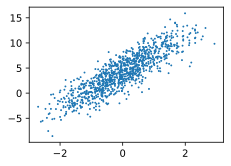

In [25]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
print(features[:, 1].numpy())
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

## 2.3 读取数据
训练模型需要不断读取小批量数据样本, 每次返回batch_size（批量大小）个随机样本的特征和标签

In [37]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 随机排序列表
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

读取第一个小批量数据样本并打印,并打印:

In [38]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.4870, -1.8535],
        [-0.7602,  1.4069],
        [ 0.4673,  1.3678],
        [-0.6631,  0.3186],
        [ 1.2413,  0.5609],
        [ 2.2177,  0.7058],
        [ 2.7566, -0.4479],
        [ 0.5191, -0.7729],
        [-0.9349,  2.1222],
        [ 0.3284,  1.1672]])tensor([-1.1223,  7.4530,  9.7901,  3.9420,  8.6033, 11.0251,  8.1748,  2.6294,
         9.5488,  8.8247])


## 2.4 初始化参数

权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0
这些参数需要求梯度，设置它们的requires_grad=True


In [39]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 2.5 定义模型
$\boldsymbol{y}=\boldsymbol{X} \boldsymbol{w}+b+\epsilon$
其中w1和w2是权（weight）， b是偏差（bias），且均为标量

In [40]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

## 2.6 定义损失函数
$\ell\left(w_{1}, w_{2}, b\right)=\frac{1}{n} \sum_{i=1}^{n} \ell^{(i)}\left(w_{1}, w_{2}, b\right)=\frac{1}{n} \sum_{i=1}^{n} \frac{1}{2}\left(x_{1}^{(i)} w_{1}+x_{2}^{(i)} w_{2}+b-y^{(i)}\right)^{2}$

In [41]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 2.7 定义优化算法
$$w_{1} \leftarrow w_{1}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac{\partial \ell^{(i)}\left(w_{1}, w_{2}, b\right)}{\partial w_{1}}$$
$$w_{2} \leftarrow w_{2}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac{\partial \ell^{(i)}\left(w_{1}, w_{2}, b\right)}{\partial w_{2}}$$
$$b \leftarrow b-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac{\partial \ell^{(i)}\left(w_{1}, w_{2}, b\right)}{\partial b}$$

In [42]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

## 2.8 训练模型

In [49]:
lr = 0.03
num_epochs = 3   # 训练模型一共需要num_epochs个迭代周期
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）
    # X和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 开始下次迭代前，需要梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051


训练完成后，打印模型参数， 对比真实参数和训练产生的参数:

In [51]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, 3.4]
tensor([[1.9990],
        [3.4005]], requires_grad=True)
4.2
tensor([4.2001], requires_grad=True)
